In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

### Support Vector Machine (SVM)

SVM is another classification algorithm. The idea behind it is to find a linear separation between two classes that maximizes the distance between the linear boundary and closest points on each side:

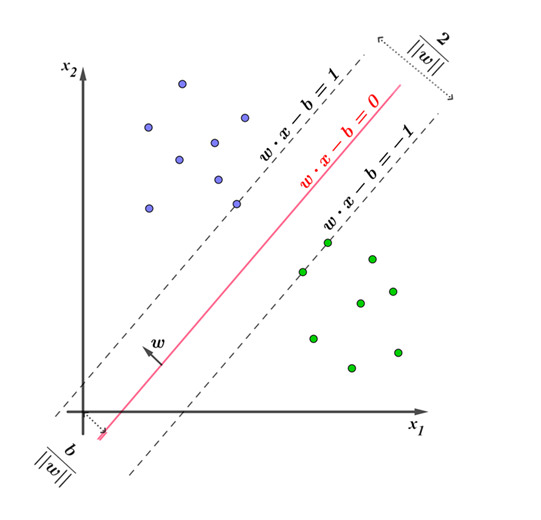

Let's look at the math behind the above pisture. Suppose we have two classes, which we will denote with either $1$ or $-1$ (i.e. target set is $\{-1,1\}$. We want to find parameters $w$ and $b$ such that $w\cdot x-b=0$ is our line a separation. Moreover, 
1. if $y^{(i)}=1$ then $w\cdot x^{(i)}-b \geq 1$;
2. if $y^{(i)}=-1$ then $w\cdot x^{(i)}-b \leq -1$

We can combine last two conditions into one formula:

$$y^{(i)}(w\cdot x^{(i)}-b) \geq 1$$

The red line is often called desicion boundary and the points on the dotted lines are called support vectors. The distance between dotted lines is equal to $\frac{2}{||w||}$ and so if we want to have largest separation we want to minimize $||w||$. If data is linearly separable, then this is a solvable problem and a margin in this case is called a hard-margin. However, usually data is not linearly separable, either because of some overlap or separation is not linear. So, we want to allow a bit of freedom for errors. This leads to a soft-margin. To do that we will introduce loss function and regularization.

The loss function that we will use in this case is called Hinge Loss Function:
$$l^{(i)}=\max\left(0, 1-y^{(i)}(w\cdot x^{(i)}-b)\right)$$

Note if we have a correct guess, then $y^{(i)}$ and $w\cdot x^{(i)}-b$ have the same sign and so $1-y^{(i)}(w\cdot x^{(i)}-b)$ is small (in fact, usually less than zero) and so $l^{(i)}=0$ (i.e no penalty). However, if our guess is not correct, then $y^{(i)}$ and $w\cdot x^{(i)}-b$ have the different sign and so $l^{(i)}=1-y^{(i)}(w\cdot x^{(i)}-b) \geq 1$ (in fact, usually $l^{(i)}\geq 2$).

And so overall our loss function is $$L=\frac{1}{N}\sum_{i=1}^N\max\left(0, 1-y^{(i)}(w\cdot x^{(i)}-b)\right)$$

Since $max$ is in essence a piece-wise function, to find gradient we have to look at pieces separatelly. And so, 

1. If the guess is correct (i.e.  $y^{(i)}(w\cdot x^{(i)}-b) \geq 1$ ), then $l^{(i)}=0$, and so $\frac{\partial l^{(i)}}{\partial w}=0$ and $\frac{\partial l^{(i)}}{\partial b}=0$.
2. Otherwise, $l^{(i)}=1-y^{(i)}(w\cdot x^{(i)}-b)$, and so $\frac{\partial l^{(i)}}{\partial w}=-y^{(i)}x^{(i)}$ and $\frac{\partial l^{(i)}}{\partial b}=y^{(i)}$.

Before we implement this let me create 3 data sets (one is linearly separable, one is separable by a circle and one is separable by a wave curve).

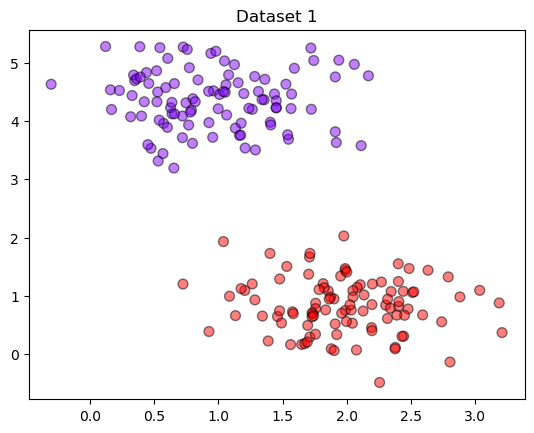

In [4]:
X1, y1 = make_blobs(n_samples=200, centers=2,random_state=0, cluster_std=0.50)   # use std=0.9 for overlap example

plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='rainbow', edgecolor='k',alpha=.5)
plt.title("Dataset 1")
plt.show()

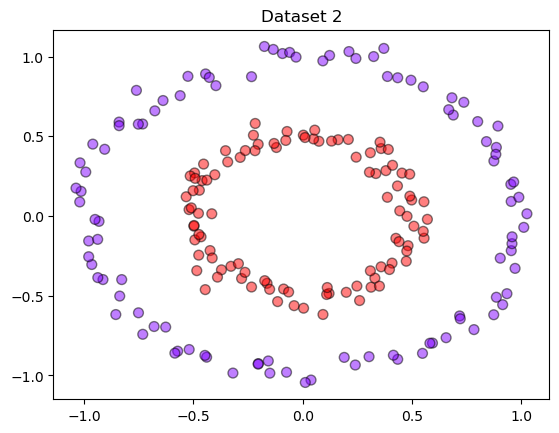

In [5]:
X2, y2  = make_circles(n_samples=200, factor=.5, noise=.05)
#
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='rainbow', edgecolor='k',alpha=.5)
plt.title("Dataset 2")
plt.show()

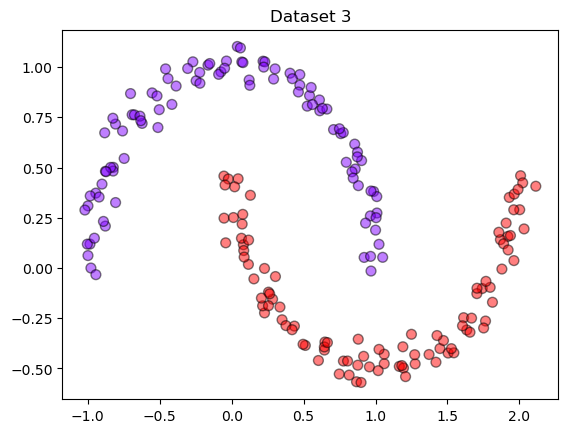

In [6]:
X3, y3 = make_moons(n_samples=200, noise=.05)
#
plt.scatter(X3[:, 0], X3[:, 1], c=y3, s=50, cmap='rainbow', edgecolor='k',alpha=.5)
plt.title("Dataset 3")
plt.show()

I will also have another helper function to draw decision boundary and the margin between classes.

In [36]:
def plot_svm(X, y, w, b, title ='Plot for linear SVM'):    

    def get_hyperplane(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure(figsize=(8,8))
    plt.scatter(X[:,0], X[:,1], marker='o',cmap='rainbow', s=50, edgecolor='k',c=y, alpha=0.7)

    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])

    x1_1 = get_hyperplane(x0_1, w, b, 0)
    x1_2 = get_hyperplane(x0_2, w, b, 0)

    x1_1_m = get_hyperplane(x0_1, w, b, -1)
    x1_2_m = get_hyperplane(x0_2, w, b, -1)

    x1_1_p = get_hyperplane(x0_1, w, b, 1)
    x1_2_p = get_hyperplane(x0_2, w, b, 1)

    plt.plot([x0_1, x0_2],[x1_1, x1_2], 'k--')
    plt.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'y')
    plt.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'y')

    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    plt.ylim([x1_min-0.5,x1_max+0.5])
    
    plt.title(title)
    plt.show()

Finally let's implement SVM. We will also add L2-regularization.

In [8]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_epoch=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_epoch = n_epoch
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        yc = np.where(y <= 0, -1, 1)

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_epoch):
            for idx, x_i in enumerate(X):
                condition = yc[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.lr * (
                        2 * self.lambda_param * self.weights - np.dot(x_i, yc[idx])
                    )
                    self.bias -= self.lr * yc[idx]

    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

In [32]:
lr=0.01
lambda_param=0.01
n_epoch=1000

model1=SVM(learning_rate=lr, lambda_param=lambda_param, n_epoch=n_epoch)
model1.fit(X1, y1)

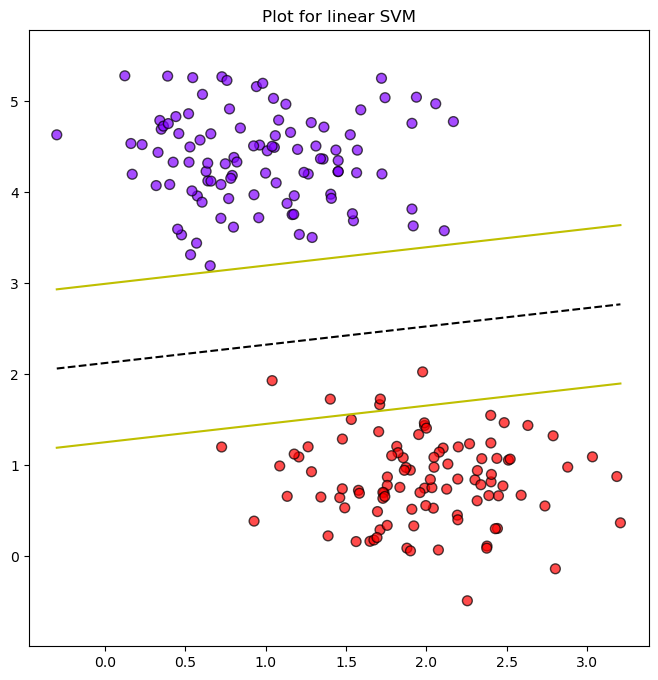

In [37]:
plot_svm(X1, y1, model1.weights, model1.bias)

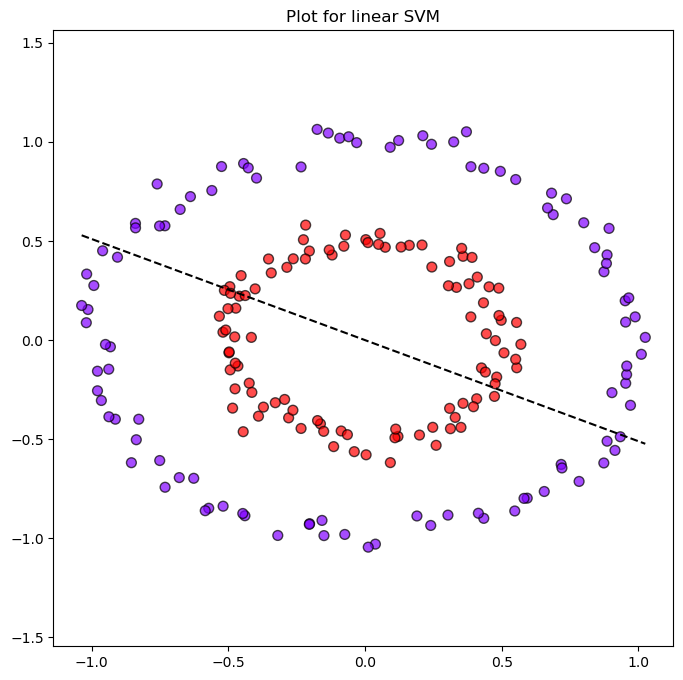

In [38]:
model2=SVM(learning_rate=lr, lambda_param=lambda_param, n_epoch=n_epoch)
model2.fit(X2, y2)
plot_svm(X2, y2, model2.weights, model2.bias)

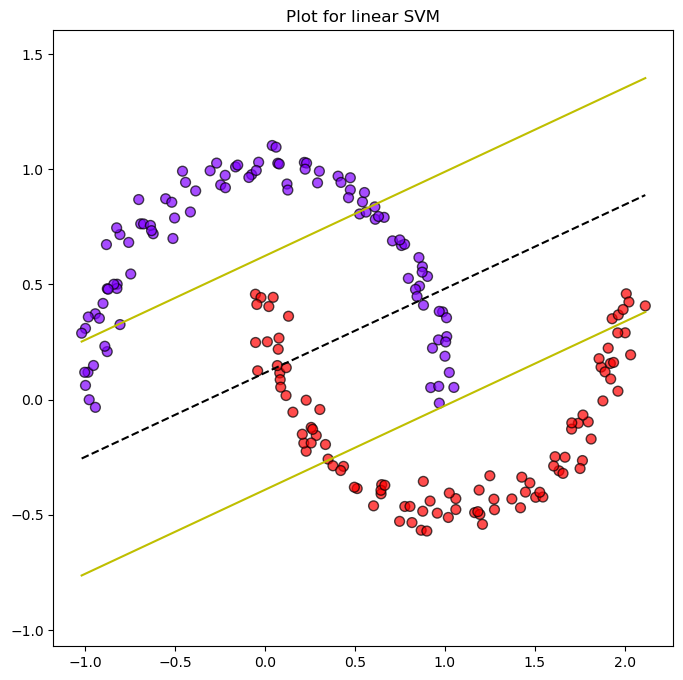

In [39]:
model3=SVM(learning_rate=lr, lambda_param=lambda_param, n_epoch=n_epoch)
model3.fit(X3, y3)
plot_svm(X3, y3, model3.weights, model3.bias)

As we can see, SVM did well in the first case, and not surprisingly not great in the last two cases. However, the strenght of SVM lies in the use of kernels. However, before we look at them we need to understand a dual optimization problem.

### Dual Optimization Problem and Lagrangian

Recall our original SVM optimization problem. We want to minimize $\frac{1}{2}||w||^2$ (it's the same as minimizing $||w||$) given constrains $y^{(i)}(w\cdot x^{(i)}-b)-1\geq 0$ (we moved 1 to the other side of inequality). We can define a Lagrangian function: $$\mathscr{L}(w,b,\alpha)=\frac{1}{2}||w||^2 - \sum_{i=1}^N \alpha_i\left(y^{(i)}(w\cdot x^{(i)}-b)-1\right),$$ and pose a dual optimization problem:

$$\max_{\alpha_i \geq 0}\left(\min_{w,b}(\mathscr{L}(w,b,\alpha))\right)$$

In words, for every choice of $\alpha_i$, we want to minimize the Lagrangian, and then among all those minimums, we will pick the largest one. That final choice produces $w$ and $b$ that are the solution to optimization problem. And the nice part is that this choice is also a solution to our original problem. 

We will partially solve this optimization now. Let's look at the inner minimum $\min_{w,b}(\mathscr{L}(w,b,\alpha))$. To find this minimum, we need partial derivatives:
$$\frac{\partial \mathscr{L}}{\partial w}=w-\sum_{i=1}^N \alpha_iy^{(i)}x^{(i)}=0$$
and so $$w=\sum_{i=1}^N \alpha_iy^{(i)}x^{(i)}.$$

The other derivative is 
$$\frac{\partial \mathscr{L}}{\partial b}={\bf \alpha\cdot y}=0$$

Substituting this into our dual problem we get:

$$\max_{\alpha_i \geq 0}\left( \sum_i\alpha_i -\frac{1}{2}\sum_{i,j}\alpha_i\alpha_jy^{(i)}y^{(j)}(x^{(i)}\cdot x^{(j)})\right)$$

This may look quite complicated, but it gives us few nice things:

1. Notice that this problem deals only with $x^{(i)}\cdot x^{(j)}$ product. So, optimization problem depends ONLY on dot product of data points, and not the data points themselves.
2. If our data has too many features (think pictures), dual problem is less expensive.
3. Only support vectors should be contributing to optimization problem and so most $\alpha$'s should be zero.

Note: the equivalence between optimization problem and its dual problem is not always true, but in this case it is. If you want to see more details and more in depth dive, you can check this video: https://www.youtube.com/watch?v=wbtHw4U-F6s

Now we are ready for Kernels

### Kernel SVM

To overcome the problem of non-linear separation, we will use a couple of tricks. First trick is moving our data into higher dimension where linear separation is possible. For example, in our circular data, all red points have smaller norm than all blue points. So we can add third dimension like so: $(x_1, x_2) \rightarrow (x_1, x_2, x_1^2+x_2^2)$ It will look like this:

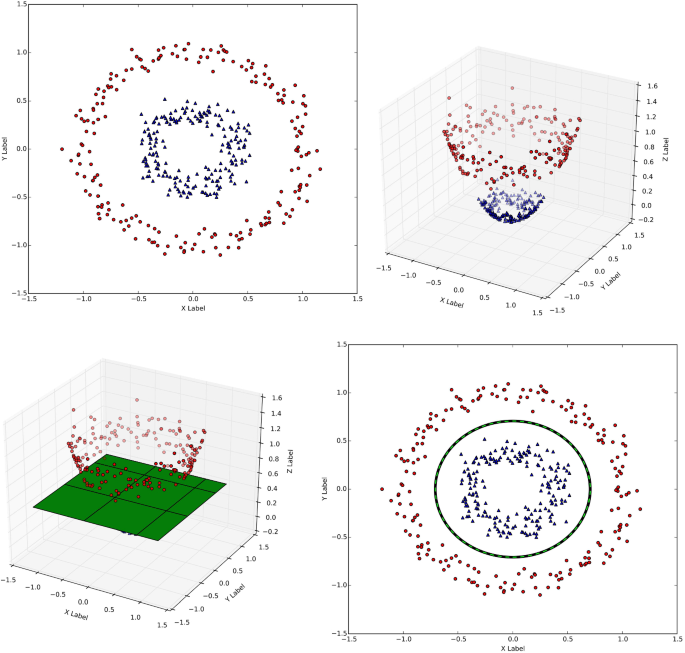

So, now we have a plane (green) that separates our classes. If we move that plane back to original 2 dimension, we get a circle that separates our original data. Different distribution of data may require different transformations and it is hard to know ahead of time what can work. We can slightly generalize this. Instead of going directly to the norm, we ,for example, can look at all quadratic relations our features may have:

$$\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \rightarrow^T \begin{bmatrix}  1\\  x_1 \\  x_2 \\  x_1x_2 \\  x_1^2 \\ x_2^2 \end{bmatrix}$$

Taking Lagrangian into account, we basically need to consider all dot products $T({\bf x^{(i)}})\cdot T({\bf x^{(j)}})$. For simplicity let me rename $x^{(i)}$ as $x$ and $x^{(j)}$ as $y$. So, now we need to consider all dot products $T(x)\cdot T(y)$

This approach has a couple of big problems. Notice, this transformation just moved us from 2 dimension to 6 (In fact, in some cases $T$ can give us infinite dimensional space). The computational complexity grows very fast the more features we have and the more relations between features we want to have.  And so here the second trick comes in : Kernels. 

Kernel is just a function that lets us compute this product: $K(x, y)=T(x)\cdot T(y)$ without actually performing it and using the dot product $x \cdot y$ instead. We will be able replace $x\cdot y$ in our algorithm with  $K(x, y)$ and not deal with high dimensions.


For example, let  $K(x, y)=(1+x\cdot y)^2=(1+x_1y_1+x_2y_2)^2$. If we expand we will get 6 different types of terms: $\{1, x_1y_1, x_2y_2, x_1^2y_1^2, x_2^2y_2^2, x_1y_1x_2y_2\}$. These are precisely the 6 terms we would get when we do $T(x) \cdot T(y)$.

Not every function can be a Kernel. To check if a given function is a Kernel is beyond the scope of this course (Requires some Linear Algebra). However here is a list of common kernels:

1. Linear kernel: $K(x,y)=x\cdot y$. This is just a regular SVM.

2. Polynomial Kernel: $K(x,y)=(c+x\cdot y)^d$, where $c>0$ and $d$ is a degree.

3. Gaussian Kernel (a.k.a. RBF): $K(x,y)=e^{\left(\frac{||x-y||^2}{\sigma^2}\right)}$

Let's see how this works in practice.

In [47]:
class SVM_Kernel:

    def __init__(self, kernel='poly', degree=2, var=0.1, n_epoch=1000, lr= 0.001):
        self.alpha = None
        self.b = 0
        self.degree = degree
        self.C = 1
        self.var = var
        self.n_epoch = n_epoch
        self.lr = lr

        if kernel == 'poly':
            self.kernel = self.polynomial_kernel # polynomial kernel
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernel # guassian kernel

    def polynomial_kernel(self,X,Z):
        return (1 + X.dot(Z.T))**self.degree #(c + X.y)^degree
        
    def gaussian_kernel(self, X,Z):
        return np.exp(-(1 / self.var ) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2) #e ^-(1/ σ2) ||X-y|| ^2
    
    def fit(self,X,y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0]) 

        y_mul_kernal = np.outer(y, y) * self.kernel(X, X) # yi yj K(xi, xj)

        for i in range(self.n_epoch):
            gradient = self.ones - y_mul_kernal.dot(self.alpha) # 1 – yi ∑ αj yj K(xj, xi)

            self.alpha += self.lr * gradient # α = α + lr*(gradient) to maximize
            self.alpha[self.alpha > self.C] = self.C # 0<α<C
            self.alpha[self.alpha < 0] = 0 # 0<α<C

            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_mul_kernal) # ∑αi – (1/2) ∑i ∑j αi αj yi yj K(xi, xj)
            
        alpha_index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        
        # for bias b, we will only consider α which are 0<α<C 
        b_list = []        
        for index in alpha_index:
            b_list.append(y[index] - (self.alpha * y).dot(self.kernel(X, X[index])))

        self.b = np.mean(b_list) # avgC≤αi≤0{ yi – ∑αjyj K(xj, xi) }
            
    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

  
    def plot(self, title='Plot for non linear SVM'):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap='rainbow', edgecolor='k', alpha=.7)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx = np.linspace(xlim[0], xlim[1], 50)
        yy = np.linspace(ylim[0], ylim[1], 50)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self.decision_function(xy).reshape(XX.shape)
        ax.contour(XX, YY, Z, levels=[-1, 0, 1],linestyles=['-', '--', '-'], colors=['y', 'k', 'y'])
        plt.title(title)
        plt.show()

Accuracy:  1.0


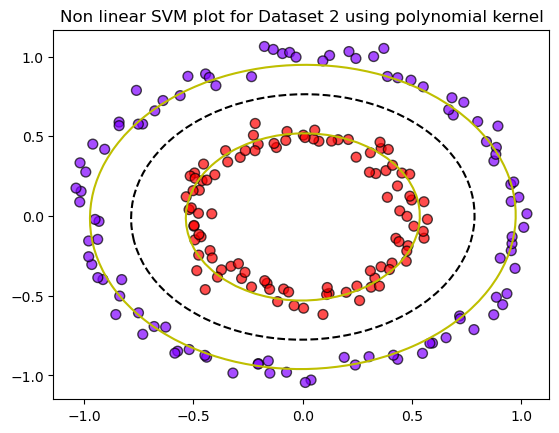

In [48]:
svm_poly = SVM_Kernel(kernel = 'poly',degree=2)
y2g = np.where(y2 <= 0, -1, 1)
svm_poly.fit(X2,y2g)
print("Accuracy: ", svm_poly.score(X2,y2g))
svm_poly.plot('Non linear SVM plot for Dataset 2 using polynomial kernel')

Accuracy:  1.0


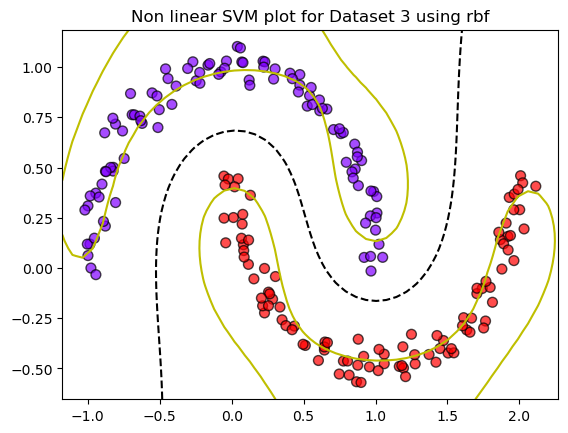

In [49]:
var=X3.var()
y3g = np.where(y3 <= 0, -1, 1)
svm_rbf = SVM_Kernel(kernel = 'rbf', var=var)
svm_rbf.fit(X3,y3g)
print("Accuracy: ", svm_rbf.score(X3,y3g))
svm_rbf.plot('Non linear SVM plot for Dataset 3 using rbf')

### Sklearn library

Let's redo above examples using sklearn

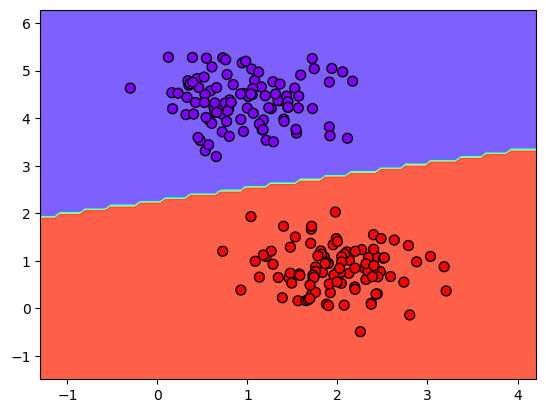

In [50]:
svm_model1=svm.SVC(kernel='linear')
svm_model1.fit(X1, y1)


DecisionBoundaryDisplay.from_estimator(
        svm_model1,
        X1,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X1[:, 0], X1[:, 1], 
            c=y1, 
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

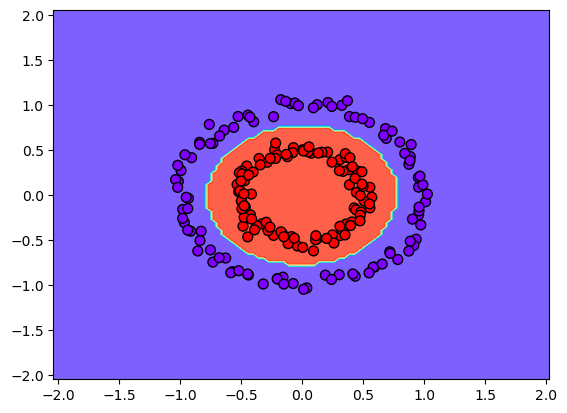

In [51]:
svm_model2=svm.SVC(kernel='poly', degree=2)
svm_model2.fit(X2, y2)

DecisionBoundaryDisplay.from_estimator(
        svm_model2,
        X2,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X2[:, 0], X2[:, 1], 
            c=y2, 
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

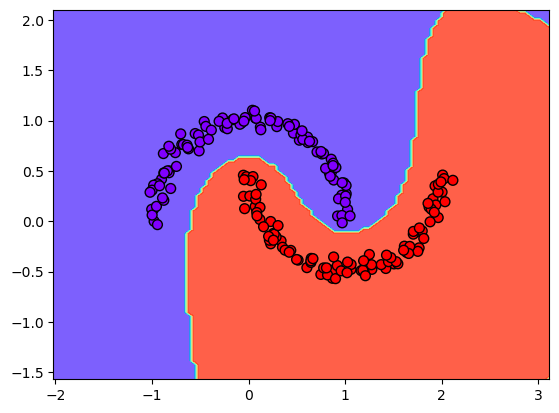

In [52]:
svm_model3=svm.SVC(kernel='rbf')
svm_model3.fit(X3, y3)

DecisionBoundaryDisplay.from_estimator(
        svm_model3,
        X3,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X3[:, 0], X3[:, 1], 
            c=y3, 
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

### Multiclass SVM

While SVM can be used for multiclass classification, it doesn't work as natural as logistic regression. In essence, we would use either OVO or OVR approach.



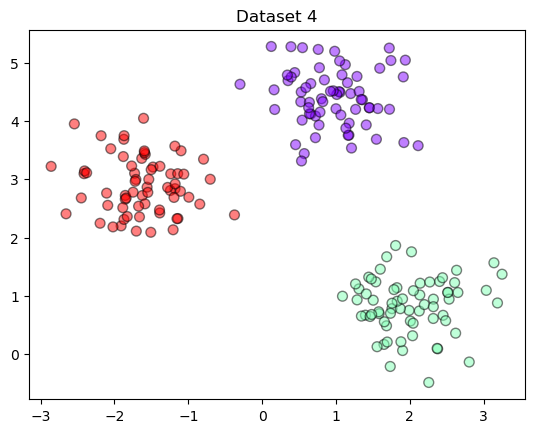

In [53]:
X4, y4 = make_blobs(n_samples=200, centers=3,random_state=0, cluster_std=0.50)   # use std=0.9 for overlap example

plt.scatter(X4[:, 0], X4[:, 1], c=y4, s=50, cmap=plt.cm.rainbow,edgecolor='black',alpha=.5)
plt.title("Dataset 4")
plt.show()

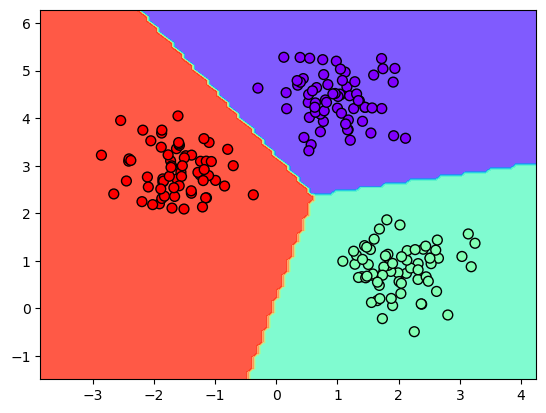

In [54]:
svm_model4=svm.LinearSVC() #by default uses OVR
svm_model4.fit(X4, y4)

DecisionBoundaryDisplay.from_estimator(
        svm_model4,
        X4,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X4[:, 0], X4[:, 1], 
            c=y4,
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

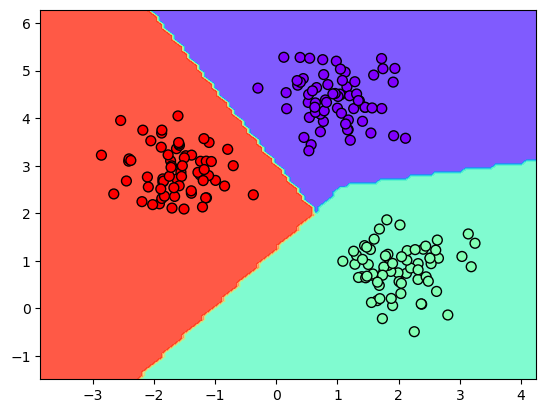

In [55]:
svm_model4=svm.SVC(kernel='linear' ) #by default uses OVO
svm_model4.fit(X4, y4)

DecisionBoundaryDisplay.from_estimator(
        svm_model4,
        X4,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X4[:, 0], X4[:, 1], 
            c=y4,
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()